In [1]:
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch import nn

In [64]:
data_path = './data'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified
Files already downloaded and verified


In [65]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [4]:
cov = nn.Conv2d(3, 16, kernel_size=3, padding=1)
cov.weight.shape, cov.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

Files already downloaded and verified


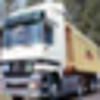

In [18]:
base_cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
base_cifar10[1][0].resize((100, 100))

torch.Size([3, 32, 32]) torch.Size([1, 16, 32, 32])


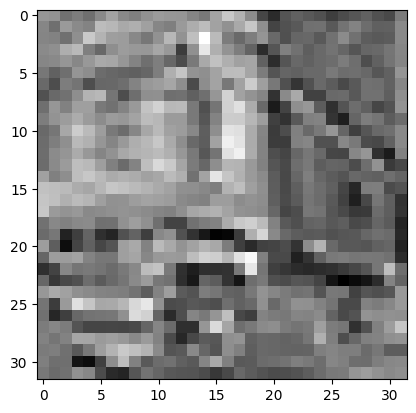

In [33]:
img, _ = cifar10[1]
output = cov(img.unsqueeze(0))
print(img.shape, output.shape)
plt.imshow(output[0, 0].detach(), cmap='gray')

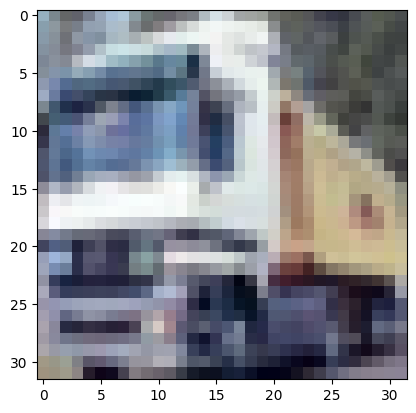

In [23]:
def show_img(i_img):
    max_val = i_img.max()
    min_val = i_img.min()
    n_img = (i_img - min_val) / (max_val - min_val)
    plt.imshow(n_img.permute(1, 2, 0))
    
show_img(img)

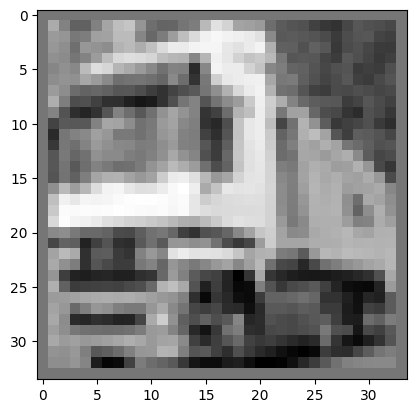

In [24]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)
    
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')

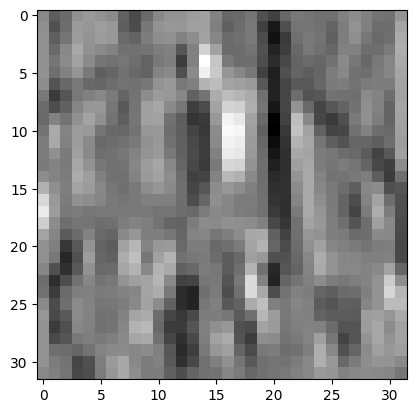

In [28]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                     [-1.0, 0.0, 1.0],
                                     [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray') 

In [29]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [31]:
model = nn.Sequential(
    # 1 * 3 * 32 * 32 
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    # 1 * 16 * 32 * 32
    nn.Tanh(),
    nn.MaxPool2d(2),
    # 1 * 16 * 16 * 16
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    # 1 * 8 * 16 * 16
    nn.Tanh(),
    nn.MaxPool2d(2),
    # 1 * 8 * 8 * 8
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [38]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.vieww(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)

        return out

In [39]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [61]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out

model = Net()
model(img.unsqueeze(0))

tensor([[ 0.0422, -0.1576]], grad_fn=<AddmmBackward0>)

In [66]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)))
            
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(100, optimizer, model, loss_fn, train_loader)

2023-09-03 10:39:16.182232 Epoch 1, Training loss 0.5662270754006258
2023-09-03 10:39:43.281640 Epoch 10, Training loss 0.3327070885592965
2023-09-03 10:40:13.574153 Epoch 20, Training loss 0.29686029786896556
2023-09-03 10:40:43.910632 Epoch 30, Training loss 0.27353617482504267
2023-09-03 10:41:14.278967 Epoch 40, Training loss 0.2530620214855595
2023-09-03 10:41:44.589335 Epoch 50, Training loss 0.23374818744742945
2023-09-03 10:42:14.951867 Epoch 60, Training loss 0.22033813144940478
2023-09-03 10:42:46.173530 Epoch 70, Training loss 0.20337140284905766
2023-09-03 10:43:18.570739 Epoch 80, Training loss 0.18926437241826088
2023-09-03 10:43:51.379939 Epoch 90, Training loss 0.17465511192182068
2023-09-03 10:44:23.316253 Epoch 100, Training loss 0.16125731433557858


In [68]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
            print('Accuracy {}: {:.2f}'.format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


In [69]:
torch.save(model.state_dict(), data_path + '/birds_vs_airplanes.pt')

In [70]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.
